In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import ast
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

%load_ext lab_black

In [32]:
from albumentations import (
    Compose,
    BboxParams,
    HorizontalFlip,
    VerticalFlip,
    ToGray,
    OneOf,
    GaussNoise,
    MotionBlur,
    MedianBlur,
    Blur,
    CLAHE,
    Emboss,
    RandomBrightnessContrast,
    HueSaturationValue,
    Resize,
    Sharpen,
)

## Data Loading and formatting

In [3]:
# Dataset:
"https://www.kaggle.com/code/artgor/object-detection-with-pytorch-lightning"
"https://www.kaggle.com/code/pestipeti/pytorch-starter-fasterrcnn-train/notebook"

'https://www.kaggle.com/code/pestipeti/pytorch-starter-fasterrcnn-train/notebook'

In [4]:
# DIR_INPUT = '/kaggle/input/global-wheat-detection'
TRAIN_DIR = f"../data/wheat/train"
TEST_DIR = f"../data/wheat/test/"

In [5]:
df = pd.read_csv("../data/wheat/train.csv")

In [6]:
df.tail()

,image_id,width,height,bbox,source
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2
147792,5e0747034,1024,1024,"[875.0, 740.0, 94.0, 61.0]",arvalis_2


In [7]:
def PIL_read(path: str) -> np.ndarray:
    img = Image.open(path)
    img = img.convert("RGB")  # is this necessary?
    img = np.array(img, dtype=np.uint8)
    return img

### Train/Validate Split
20% Validation

In [8]:
image_list = df["image_id"].unique()
image_list.size

3373

In [9]:
valid_image_list = image_list[-round(3373 * 0.2) :]
train_image_list = image_list[: -round(3373 * 0.2)]
print(
    f"{len(train_image_list)} training images and {len(valid_image_list)} validation images"
)

2698 training images and 675 validation images


In [10]:
# train_paths = [
#     os.path.join(TRAIN_DIR, f"{filename}.jpg") for filename in train_image_list
# ]
# valid_paths = [
#     os.path.join(TRAIN_DIR, f"{filename}.jpg") for filename in valid_image_list
# ]
# train_images = [PIL_read(f) for f in train_paths]
# valid_images = [PIL_read(f) for f in valid_paths]

### Bounding boxes
Lets make the format into 4 columns of our dataframe

In [11]:
df["bbox"]

0          [834.0, 222.0, 56.0, 36.0]
1         [226.0, 548.0, 130.0, 58.0]
2         [377.0, 504.0, 74.0, 160.0]
3         [834.0, 95.0, 109.0, 107.0]
4         [26.0, 144.0, 124.0, 117.0]
                     ...             
147788      [64.0, 619.0, 84.0, 95.0]
147789    [292.0, 549.0, 107.0, 82.0]
147790    [134.0, 228.0, 141.0, 71.0]
147791     [430.0, 13.0, 184.0, 79.0]
147792     [875.0, 740.0, 94.0, 61.0]
Name: bbox, Length: 147793, dtype: object

In [12]:
df["bbox"] = (
    df["bbox"].str.replace("[", "", regex=False).str.replace("]", "", regex=False)
)
df[["x", "y", "w", "h"]] = (
    df["bbox"].str.split(",", expand=True).apply(pd.to_numeric, errors="coerce")
)

In [13]:
df.drop(columns="bbox", inplace=True)

In [14]:
df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


### Plot some samples

In [15]:
# selected_image_nr = 1
# image = train_images[selected_image_nr]
# image_id = image_list[selected_image_nr]
# boxes = df[df["image_id"] == image_id][["x", "y", "w", "h"]].astype(int).values
# boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
# boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# for box in boxes:
#     cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 3)

# ax.set_axis_off()
# ax.imshow(image)

In [16]:
# # clear memory
# del train_images
# del valid_images

In [17]:
train_df = df[df["image_id"].isin(train_image_list)]
valid_df = df[df["image_id"].isin(valid_image_list)]
print(f"Training_df shape: {train_df.shape};  Validation_df shape: {valid_df.shape}")

Training_df shape: (122577, 8);  Validation_df shape: (25216, 8)


## Wheat Dataset

In [18]:
# Work with Data augmentation
def get_aug(aug):
    return Compose(
        aug, bbox_params=BboxParams(format="pascal_voc", label_fields=["label"])
    )

In [33]:
class WheatDataset(Dataset):
    def __init__(self, df, img_size, image_dir, mode="train") -> None:
        super(WheatDataset, self).__init__()
        self.df = df
        self.img_size = img_size
        self.image_dir = image_dir
        self.image_ids = self.df["image_id"].unique()
        self.mode = mode

        if self.mode == "train":
            np.random.shuffle(self.image_ids)
        self.train_trainsforms = get_aug(
            [
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ToGray(p=0.01),
                GaussNoise(p=0.2),
                OneOf(
                    [
                        MotionBlur(p=0.2),
                        MedianBlur(blur_limit=3, p=0.1),
                        Blur(blur_limit=3, p=0.1),
                    ],
                    p=0.2,
                ),
                OneOf(
                    [
                        CLAHE(),
                        Sharpen(),
                        Emboss(),
                        RandomBrightnessContrast(),
                    ],
                    p=0.25,
                ),
                HueSaturationValue(p=0.25),
            ]
        )
        self.resize_transforms = get_aug(
            [Resize(height=self.img_size, width=self.img_size, interpolation=1, p=1)]
        )

    def __len__(self):
        return len(self.image_ids)

    def resize_image(self, image, boxes):
        cats = np.ones(boxes.shape[0], dtype=int)
        annotations = {"image": image, "bboxes": boxes, "category_id": cats}
        augmented = self.resize_transforms(**annotations)
        image = augmented["image"]
        boxes = np.array(augmented["bboxes"])
        return image, boxes

    def refine_boxes(self, boxes):
        result_boxes = []
        for box in boxes:
            if box[2] - box[0] < 10 or box[3] - box[1] < 10:
                continue
            result_boxes.append(box)
        result_boxes = np.array(result_boxes)
        return result_boxes

    def load_image_and_boxes(self, image_id):
        records = self.df[self.df["image_id"] == image_id]
        img = PIL_read(f"{self.image_dir}/{image_id}.jpg")
        boxes = records[["x", "y", "w", "h"]].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        boxes = self.refine_boxes(boxes)
        if len(boxes) > 0:
            boxes = np.array(boxes, dtype=float)
        else:
            boxes = np.array([], dtype=float).reshape(0, 4)
        return img, boxes

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image, boxes = self.load_image_and_boxes(image_id)
        if self.img_size != 1024:
            image, boxes = self.resize_image(image, boxes)

        if boxes.shape[0] == 0:
            target = {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros(0, dtype=torch.int64),
                "area": torch.zeros(0, dtype=torch.float32),
                "iscrowd": torch.zeros((0,), dtype=torch.int64),
            }
        else:
            target = {}
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
            target["labels"] = torch.ones((boxes.shape[0],), dtype=torch.int64)
            target["area"] = torch.as_tensor(area, dtype=torch.float32)
            target["iscrowd"] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        image = image.astype(np.float32)
        image /= 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)
        return image, target, image_id

# Continue Here

## Work with the model

In [20]:
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
#     weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT"
# )
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

d:\Python\General\03_Projects\neural_nets\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Python\General\03_Projects\neural_nets\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [22]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [34]:
# The collate_fn function is used by the DataLoader to process the input data in batches.
def collate_fn(batch):
    return tuple(zip(*batch))


train_dataset = WheatDataset(train_df, 1024, image_dir=TRAIN_DIR, mode="train")
# valid_dataset = WheatDataset(valid_df,1024, img_dir=TRAIN_DIR, mode="train")


# split the dataset in train and valid set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn
)

# valid_data_loader = DataLoader(
#     valid_dataset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn
# )

In [35]:
# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Let´s get some samples from the dataloader

In [36]:
images, targets, image_ids = next(iter(train_data_loader))
# examples = enumerate(train_data_loader)
# batch_idx, (images, targets, image_ids) = next(examples)

In [37]:
images = list(image.to(device) for image in images)

In [38]:
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [39]:
boxes = targets[0]["boxes"].cpu().numpy().astype(np.int32)
sample = images[0].permute(1, 2, 0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


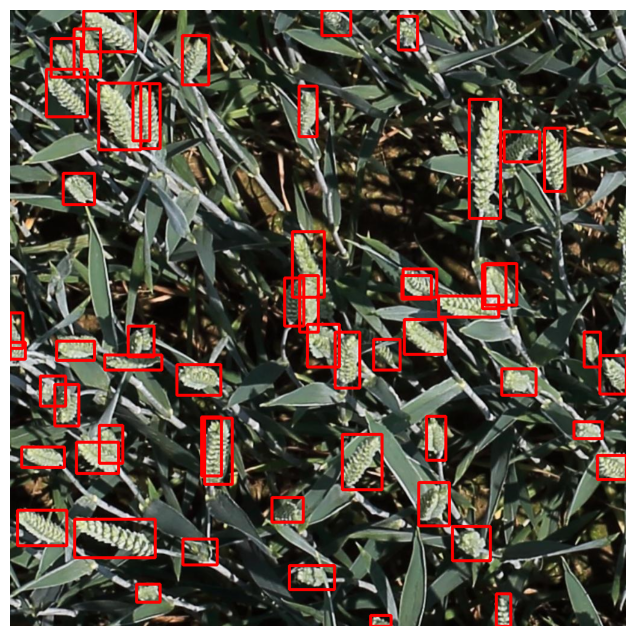

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 3)

ax.set_axis_off()
ax.imshow(sample)

In [ ]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = None

num_epochs = 2

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()

    for images, targets, image_ids in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

## Validation data

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

In [ ]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

## Persist

In [ ]:
torch.save(model.state_dict(), "fasterrcnn_resnet50_fpn.pth")